In [196]:
import pandas as pd
import numpy as np
import time
import math
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as Data

train = pd.read_csv('../task2/HS300V2_clean_data/clean_train.csv')
test = pd.read_csv('../task2/HS300V2_clean_data/clean_test.csv')

In [210]:
# timer function
def timeSince(since):
    now = time.time()
    s = now-since
    m = math.floor(s/60)
    s-= m*60
    return '%dm %ds' % (m,s)

In [339]:
# design MLP network
class MLP(nn.Module):
    def __init__(self,input_size):
        super(MLP,self).__init__()
        
        # design hidden layers
        self.linear1 = nn.Linear(inputs_size,256)
        self.linear2 = nn.Linear(256,64)
        self.linear3 = nn.Linear(64,16)
        self.linear4 = nn.Linear(16,4)
        self.linear5 = nn.Linear(4,1)
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(16)
        self.bn4 = nn.BatchNorm1d(4)
        
        self.dropout = nn.Dropout(p=0.3)
        
        # choose activation function
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.sigmoid  = nn.Sigmoid()
        self.leakyRelu = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        
    def forward(self,inputs):
        
        hidden = self.linear1(inputs)
        hidden = self.bn1(hidden)
        hidden = hidden*self.sigmoid(hidden)
        hidden = self.dropout(hidden)
        
        hidden = self.linear2(hidden)
        hidden = self.bn2(hidden)
        hidden = hidden*self.sigmoid(hidden)
        hidden = self.dropout(hidden)
        
        hidden = self.linear3(hidden)
        hidden = self.bn3(hidden)
        hidden = hidden*self.sigmoid(hidden)
        hidden = self.dropout(hidden)
    
        hidden = self.linear4(hidden)
        hidden = self.bn4(hidden)
        hidden = hidden*self.sigmoid(hidden)
        hidden = self.dropout(hidden)
        
        hidden = self.linear5(hidden)
        outputs = self.tanh(hidden)
        
        return outputs


In [340]:
class pearson_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self,x,y):
        cov = torch.mean(x*y)-torch.mean(x)*torch.mean(y)
        var = torch.std(x)*torch.std(y)
        return (-1*cov/var+1)

In [341]:
# 95% data as a training set, 5% of data as a validation set
num = len(list(set(train['trade_date'])))
split_date = math.floor(num*0.95)+1215

In [342]:
train_X = train[train['trade_date']<=split_date].iloc[:,3:]
train_y = train[train['trade_date']<=split_date].iloc[:,2]
valid_X = train[train['trade_date']>split_date].iloc[:,3:]
valid_y = train[train['trade_date']>split_date].iloc[:,2]
test_X = test.iloc[:,2:]

In [343]:
# Convert dataframe to tensor 
train_X = torch.tensor(np.array(train_X),dtype=torch.float32)
train_y = torch.tensor(np.array(train_y),dtype=torch.float32)
valid_X = torch.tensor(np.array(valid_X),dtype=torch.float32)
valid_y = torch.tensor(np.array(valid_y),dtype=torch.float32)
test_X = torch.tensor(np.array(test_X),dtype=torch.float32)

In [344]:
# check the shape of the data
print(train_X.shape,valid_X.shape,test_X.shape)
print(train_y.shape,valid_y.shape)

torch.Size([597174, 282]) torch.Size([31818, 282]) torch.Size([108189, 282])
torch.Size([597174]) torch.Size([31818])


In [345]:
inputs_size = train_X.shape[1]
epoch = 15
learning_rate = 1e-3
weight_decay = 0
eps = 1e-8
batch_size = 256

In [346]:
train_dataset = Data.TensorDataset(train_X,train_y)
valid_dataset = Data.TensorDataset(valid_X,valid_y)
train_loader = Data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
valid_loader = Data.DataLoader(dataset=valid_dataset,batch_size=batch_size,shuffle=False)

In [347]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(inputs_size).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = pearson_loss().to(device)

In [348]:
for m in model.modules():
    if isinstance(m,(nn.Linear)):
        nn.init.orthogonal(m.weight)

<ipython-input-348-112bec85a79d>:3: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight)


epoch 1 time: 0m 17s
epoch 2 time: 0m 33s
epoch 3 time: 0m 51s
epoch 4 time: 1m 7s
epoch 5 time: 1m 21s
epoch 6 time: 1m 35s
epoch 7 time: 1m 53s
epoch 8 time: 2m 10s
epoch 9 time: 2m 27s
epoch 10 time: 2m 46s
epoch 11 time: 3m 3s
epoch 12 time: 3m 18s
epoch 13 time: 3m 34s
epoch 14 time: 3m 50s
epoch 15 time: 4m 7s


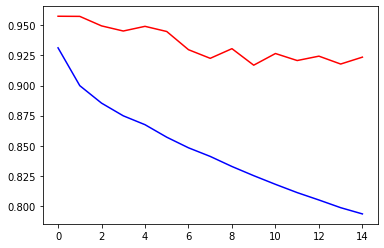

In [349]:
start = time.time()
train_loss = []
valid_loss = [] 
train_epoch_loss = 0
valid_epoch_loss = 0
for epoch in range(epoch):
    model.train()
    for t_batch_idx,(t_inputs,t_labels) in enumerate(train_loader):
        t_inputs,t_labels = t_inputs.to(device),t_labels.to(device)
        t_pred = model(t_inputs)
        t_loss = criterion(t_pred.squeeze(1),t_labels)
        optimizer.zero_grad()
        t_loss.backward()
        optimizer.step()
        train_epoch_loss+=t_loss.item()
    
    model.eval()
    for v_batch_idx,(v_inputs,v_labels) in enumerate(valid_loader):
            v_inputs,v_labels = v_inputs.to(device),v_labels.to(device)
            v_pred = model(v_inputs)
            v_loss = criterion(v_pred.squeeze(1),v_labels)
            valid_epoch_loss+=v_loss.item()
            
    
    train_loss.append(train_epoch_loss/(t_batch_idx+1))   
    valid_loss.append(valid_epoch_loss/(v_batch_idx+1))
    train_epoch_loss = 0
    valid_epoch_loss = 0 
    print('epoch %d time: %s'% (epoch+1,timeSince(start)))
    
plt.figure()
plt.plot(train_loss,'b-',valid_loss,'r-')

In [350]:
test_y = model.cpu()(test_X).detach().numpy()

In [351]:
pred = []
for i in range(test_y.shape[0]):
     pred.append([str(test.iloc[i,1]),str(test.iloc[i,0]),str(test_y[i][0])])

In [352]:
pred

[['3402', '0', '0.25435135'],
 ['3402', '1', '0.2034547'],
 ['3402', '51', '0.24806401'],
 ['3402', '55', '0.25017908'],
 ['3402', '63', '0.30233693'],
 ['3402', '69', '0.104134485'],
 ['3402', '72', '0.31189728'],
 ['3402', '74', '0.16996875'],
 ['3402', '75', '0.18938416'],
 ['3402', '78', '0.18213066'],
 ['3402', '83', '0.2513598'],
 ['3402', '87', '0.22816573'],
 ['3402', '88', '0.17161615'],
 ['3402', '96', '0.19799286'],
 ['3402', '97', '0.20500323'],
 ['3402', '106', '0.28533974'],
 ['3402', '139', '0.3351343'],
 ['3402', '153', '0.18070385'],
 ['3402', '167', '0.17451873'],
 ['3402', '214', '0.21505465'],
 ['3402', '216', '0.11805759'],
 ['3402', '219', '0.2005928'],
 ['3402', '229', '0.14655441'],
 ['3402', '235', '0.48541906'],
 ['3402', '244', '0.09429024'],
 ['3402', '270', '0.23988332'],
 ['3402', '274', '0.28658268'],
 ['3402', '288', '0.310744'],
 ['3402', '291', '0.30277872'],
 ['3402', '318', '0.24012211'],
 ['3402', '320', '0.23155086'],
 ['3402', '326', '0.33912602']

In [353]:
from BenchmarkTestTool import submit_benchmark_test

data = pred
submitter = "qiuyuan"
dataset = "HS300V2"
comment = 'MLP|BN+GLU|Dropout++|lr=1e-3,epoch=15'
submit_benchmark_test(submitter,data,dataset,comment,submit=False)

TEST STATUS: success
************************************************************
COMPLETENESS CHECK
************************************************************
average_daily_miss_num:  1
max_miss_day:  3763
max_miss_day_num:  4
max_miss_stock:  3337
max_miss_stock_num:  16
pred_miss_num:  38
pred_miss_ratio:  0.0004
pred_num:  108189
true_num:  108227

************************************************************
SUBMIT SIGNAL PERFORMANCE
************************************************************
autocorrelation:  0.6898365774024492
comment:  MLP|BN+GLU|Dropout++|lr=1e-3,epoch=15
dataset:  HS300V2
pearson:  0.04437636014673795
pearson_250:  0.03479180527146055
pearson_decay:  -6.918504768278453e-05
pearson_std:  0.08538009669783192
sid:  e2ed5d467ca621b0426c4ecb342d920d
spearman:  0.03684098087391763
submit_time:  2021-04-15 04:22:00.497574
submitter:  qiuyuan
top30_win_rate:  0.4872007366482505

************************************************************
MODEL SCORE'S EXPOSURE ON 

In [179]:
# from BenchmarkTestTool import check_test_rank

# check_test_rank(submitter="all",rank_by="pearson")

**************************************************
BENCHMARK测试榜排名:
**************************************************
*指标说明:
pearson:皮尔森相关系数
prs_dcy:信号相关性每日衰减系数
prs_250:最近250天（一年）的pearson均值
sprm:序相关性，斯皮尔曼相关系数
top30_win:信号每日前30名有正超额收益的胜率
ac:信号自相关性

0. 
+-------------------+-----------+---------+--------------+---------+
|    submit_time    | submitter | dataset |   comment    | pearson |
+-------------------+-----------+---------+--------------+---------+
| 21-04-06 12:38:18 |   ZhuLei  | HS300V2 | MLP_leakRelu | 0.05407 |
+-------------------+-----------+---------+--------------+---------+
+---------+---------+---------+--------+-----------+--------+
| prs_std | prs_dcy | prs_250 |  sprm  | top30_win |   ac   |
+---------+---------+---------+--------+-----------+--------+
|  0.0807 |  -7e-05 |  0.0454 | 0.0443 |   0.4897  | 0.6047 |
+---------+---------+---------+--------+-----------+--------+
1. 
+-------------------+-----------+---------+---------------------------------------+------